In [1]:
from datasets import list_datasets

/Users/bifnudozhao/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
all_datasets = list_datasets()
print(f'There are {len(all_datasets)} databases currently available on the hub')
print(f'The first 10 are: {all_datasets[:10]}')

/var/folders/63/hmm24s352qv_4vs09n66p97m0000gn/T/ipykernel_86901/3548995950.py:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


There are 83795 databases currently available on the hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [3]:
from datasets import load_dataset

In [4]:
emotions = load_dataset('emotion')

In [5]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
train_ds = emotions['train']
print(len(train_ds))
train_ds[0]

16000


{'text': 'i didnt feel humiliated', 'label': 0}

In [7]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [8]:
train_ds['text'][:5]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy']

In [9]:
import pandas as pd

In [10]:
emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [11]:
def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)

df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [12]:
import matplotlib.pyplot as plt

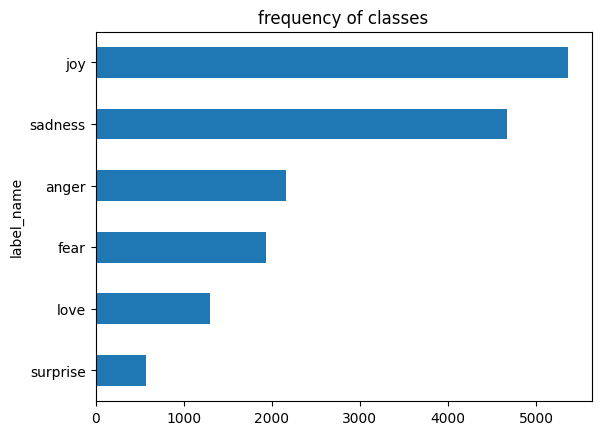

In [13]:
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('frequency of classes')
plt.show()

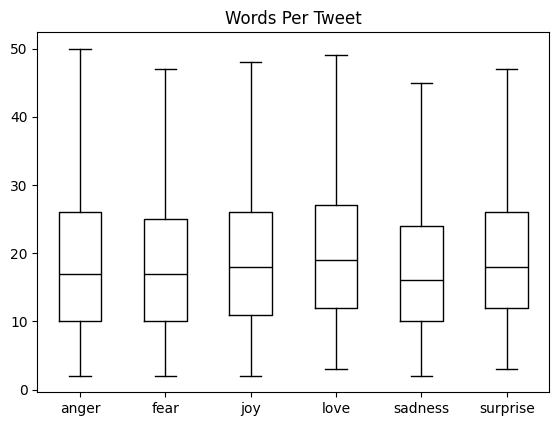

In [14]:
df['Words Per Tweet'] = df['text'].str.split().apply(len)
df.boxplot('Words Per Tweet',
           by='label_name',
           grid=False,
           showfliers=False,
           color='black')
plt.suptitle('')
plt.xlabel('')
plt.show()

In [15]:
emotions.reset_format()

喂给模型之前，字符串需要 tokenization 以及 encode。最极端的两种做法分别是根据**字母**以及根据**单词**来进行拆分。

下面根据字母进行拆分。

In [16]:
text = 'tokenizing text is a core task of NLP'
tokenized_text = list(text)
print(tokenized_text)

['t', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P']


In [17]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
token2idx

{' ': 0,
 'L': 1,
 'N': 2,
 'P': 3,
 'a': 4,
 'c': 5,
 'e': 6,
 'f': 7,
 'g': 8,
 'i': 9,
 'k': 10,
 'n': 11,
 'o': 12,
 'r': 13,
 's': 14,
 't': 15,
 'x': 16,
 'z': 17}

In [18]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[15, 12, 10, 6, 11, 9, 17, 9, 11, 8, 0, 15, 6, 16, 15, 0, 9, 14, 0, 4, 0, 5, 12, 13, 6, 0, 15, 4, 14, 10, 0, 12, 7, 0, 2, 1, 3]


In [19]:
import torch
import torch.nn.functional as F

In [20]:
input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
print(len(token2idx))
print(one_hot_encodings.shape)

18
torch.Size([37, 18])


In [21]:
print(f'Token: {tokenized_text[0]}')
print(f'Tensor index: {input_ids[0]}')
print(f'One-hot: {one_hot_encodings[0]}')

Token: t
Tensor index: 15
One-hot: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])


下面根据单词来进行拆分。

In [22]:
tokenized_text = text.split()
print(tokenized_text)

['tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP']


下面使用 subword tokenization。

In [23]:
from transformers import AutoTokenizer

model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [24]:
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [25]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '[SEP]']


使用 `AutoTokenizer` 进行分词，转化为 id，然后再转化回单词，会发现有些单词带有 `##` 前缀，这表明这个单词签名并不是空格。`[CLS]` 以及 `[SEP]` 是专门用来放在句子开头以及结尾的特殊标记。

In [26]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp [SEP]


In [27]:
print(f'vocabulary size: {tokenizer.vocab_size}')
print(f'model max len: {tokenizer.model_max_length}')
print(f'model input names: {tokenizer.model_input_names}')

vocabulary size: 30522
model max len: 512
model input names: ['input_ids', 'attention_mask']


下面将对整个 `emotions` 语料库进行分词。

In [28]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

print(tokenize(emotions['train'][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [29]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [30]:
print(emotions_encoded['train'].column_names)
print(emotions_encoded['train'][0])

['text', 'label', 'input_ids', 'attention_mask']
{'text': 'i didnt feel humiliated', 'label': 0, 'input_ids': [101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


训练分类器的整体流程如下所示

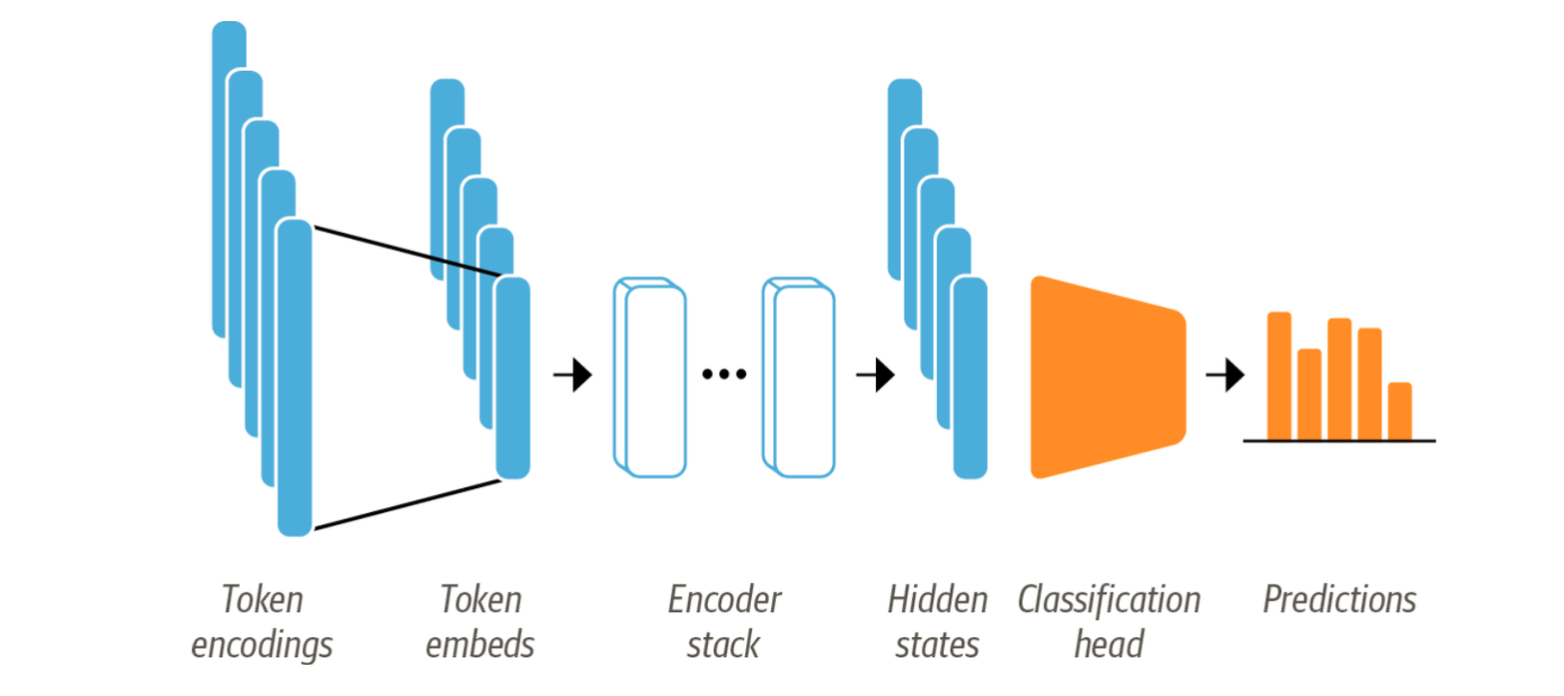

训练一个分类器有两种办法，一种是特征提取（feature extract），另一种是模型精调（fine-tuning）。下面先使用特征提取来训练。

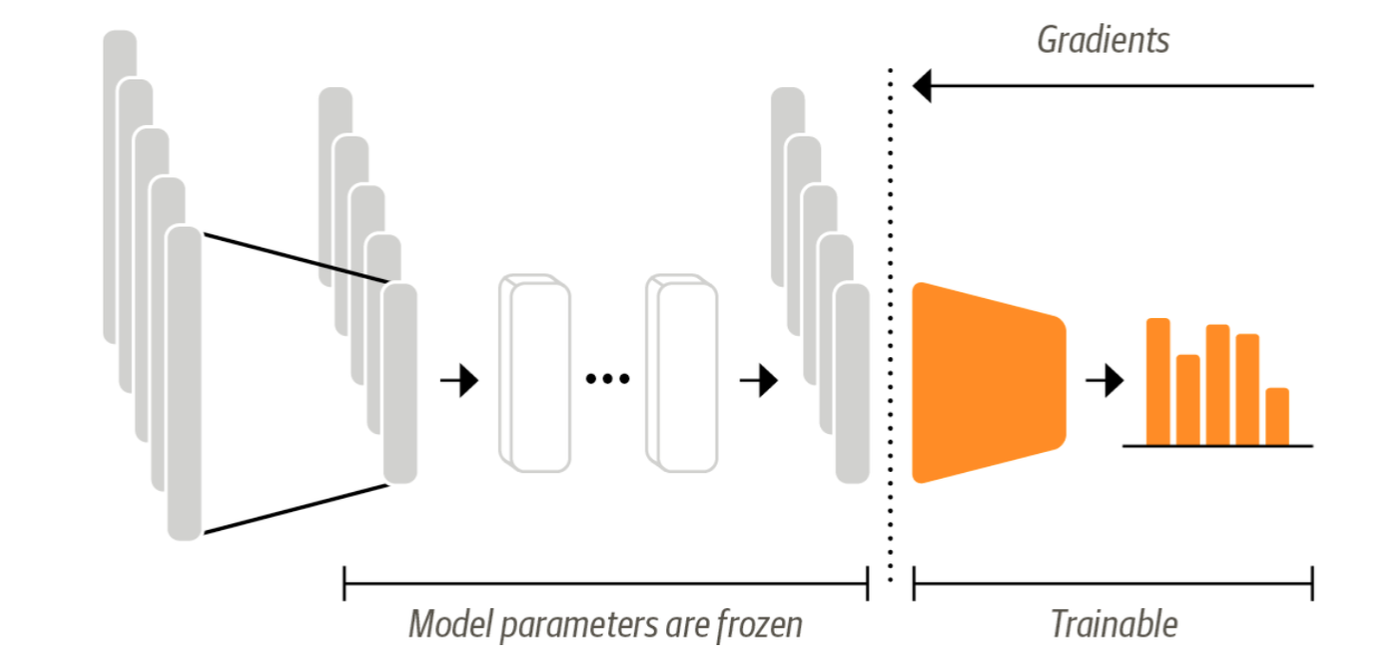

在特征提取中，预训练模型的参数被冻结，数据只被用来训练分类器，好处是简单快捷，训练的数据不需要很多，也不会破坏原来预训练模型已经学到的内容。

In [31]:
torch.cuda.is_available()

False

In [32]:
from transformers import AutoModel

model_ckpt = 'distilbert-base-uncased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModel.from_pretrained(model_ckpt).to(device)

从上面的架构图可以看到，我们训练的起点是模型输出的隐藏状态，而模型的输入是 Tokenized Encoding，所以并不需要转化为 one-hot，下面先用一个简单的例子看看隐藏状态的输出。

In [33]:
text = 'this is a test'
inputs = tokenizer(text, return_tensors='pt')
print(f"input tensor shape: {inputs['input_ids'].size()}")
inputs

input tensor shape: torch.Size([1, 6])


{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [34]:
inputs = {k:v.to(device) for k, v in inputs.items()}
# no need to keep gradient when running forward
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


In [35]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

可以看到隐藏状态的形状是 `[batch_size, n_tokens, hidden_dim]`。**通常在分类问题里，会使用 `[CLS]` 这个 token 对应的隐藏状态作为整个输入的特征，因为 `[CLS]` 是整个输入的第一个标记。所以取每个 batch 里的第 0 个元素就能获取对应的隐藏状态。**

In [36]:
def extract_hidden_states(batch):
    # place model inputs on the device
    inputs = {k:v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    # extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # return vector for [CLS] token
    return {'hidden_state': last_hidden_state[:, 0].cpu().numpy()}

In [37]:
emotions_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

In [38]:
emotions_hidden['train'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [39]:
import numpy as np

X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [43]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# scale features to [0, 1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# initialize and fit UMAP
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)
# create a dataframe of 2d embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train
df_emb.head()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


,X,Y,label
0,4.370595,6.561679,0
1,-2.892889,5.898492,0
2,5.134760,2.952863,3
3,-2.312201,3.735158,2
4,-3.315489,3.951122,3


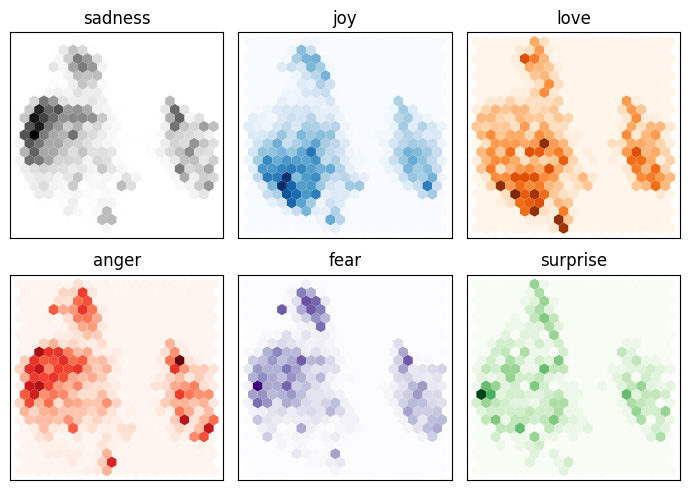

In [46]:
fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
labels = emotions['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f'label == {i}')
    axes[i].hexbin(df_emb_sub['X'],
                   df_emb_sub['Y'],
                   cmap=cmap,
                   gridsize=20,
                   linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()